# How to use a DeepLearning model to classify object images type from data using Tensorflow Keras API

The objective of this project is to use a neural network model to classify objects like horses, animals, ships


This project uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow

In [22]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

##
# matplotlib.pyplot is a collection of functions that make matplotlib work like MATLAB.
# Each pyplot function makes some change to a figure: e.g., creates a figure,
# creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc.
##
print(tf.__version__)

2.9.2


## Import the object dataset

This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images.


<table>
  <tr><td>
    <img src="https://storage.googleapis.com/tfds-data/visualization/fig/cifar10-3.0.2.png"
         alt="Cifar10 Dataset"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Cifar10 Dataset samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

In [43]:
# set the dataset variable
dataset = tf.keras.datasets.cifar10

# categorize the dataset between the training and test image sets from fashion_mnist variable'
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()


In [10]:
builder = tfds.builder('cifar10')
info = builder.info
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpa9ric7qhtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mul

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [11]:
info.features

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [25]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (7 -> 'horse')

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
horse


In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
print(info.splits)


{'test': <SplitInfo num_examples=10000, num_shards=1>, 'train': <SplitInfo num_examples=50000, num_shards=1>}


In [19]:
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

50000
['cifar10-train.tfrecord-00000-of-00001']
1


## Explore the data

Let's explore the format of the dataset before training the model.

The ouput shows there are 50,000 images in the training set, with each image represented as 32 x 32 pixels:

In [23]:
train_images.shape

(50000, 32, 32, 3)

Likewise, there are 50,000 labels in the training set:

In [15]:
len(train_labels)

50000

Each label is an integer between 0 and 9:

In [16]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [28]:
test_images.shape

(10000, 32, 32, 3)

And the test set contains 10,000 images labels:

In [29]:
len(test_labels)

10000

## Preprocess the data
**Preprocessing** means preparing (cleaning and organizing) the raw data to make it suitable for a building and training Machine Learning models.

The data must be preprocessed before training the network. If you inspect the ninth image in the training set, you will see that the pixel values fall in the range of 0 to 255:

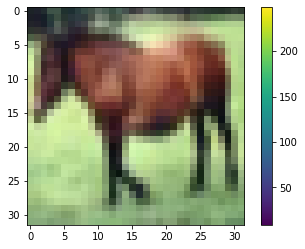

In [56]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [67]:

train_images = train_images / 255.0
test_images = test_images / 255.0


In [101]:
image_size = [28, 28]
train_images = tf.image.resize(train_images, tf.constant(image_size))
test_images = tf.image.resize(train_images, tf.constant(image_size))
print(train_images.shape)
print(test_images.shape)

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

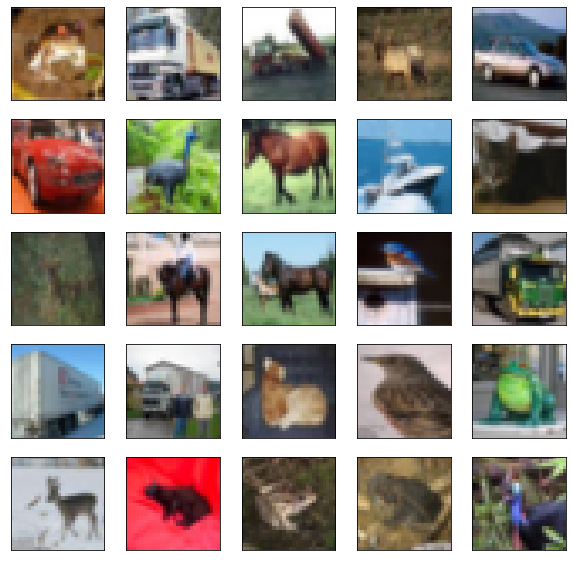

In [103]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

If you inspect the 7th image this time in the training set, you will see that the pixel values fall in the range of 0 to 1. This means our preproccesing was successful.

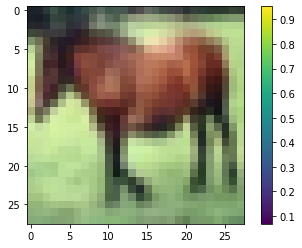

In [104]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [127]:
# The Sequential model API is a way of creating deep learning models where an instance of the Sequential class is created and model layers are created and added to it.

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(10) # one of the 10 classes
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [128]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [129]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


ValueError: ignored

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [ ]:
# The softmax function is used as the activation function in the output layer of neural network models
# that predict a multinomial probability distribution

# The activation function defines the output of a neuron / node given an input or set of input (output of multiple neurons).

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
#test image dataset prediction.

predictions[0]

# the prediction results are an array because A prediction is an array of 10 numbers (10 labels / categories).
# They represent the model's "confidence" that the image [0] corresponds to each of the 10 different articles of clothing.
# You can see which label has the highest confidence value:

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [ ]:
# to drill down to the most probable label, use the np.argmax function

np.argmax(predictions[0])

# the output is 9 which corresponds to the 'Ankle boot' label

As a reminder, here's the first test image `[0]` which the Model has made the prediction for. We had 10 labels each represented with an integer between `0-9`. Image 0 is an ankle boot, label `[9]`

`['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']`

In [ ]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [ ]:
test_labels[0]

Graph this to look at the full set of 10 class predictions.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [ ]:
i = 0 # i is 0 for the first image, ankle boot
plt.figure(figsize=(6,3)) # Width, height in inches.
plt.subplot(1,2,1) # Three integers (nrows, ncols, index).
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
i = 12 # i is 12 for the 12th image, sandal / sneaker
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

In [ ]:
plt.figure()
plt.imshow(test_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

Now predict the correct label for this image:

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

And the model predicts a label as expected.